<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/AprendizajePorRefuerzo-PongDeterministic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teoría

## Objetivo: 
Repasar los conceptos vistos en clase.

La puntuación de este bloque es de 4 puntos sobre la nota final.

**Define brevemente qué es el aprendizaje por refuerzo. ¿Qué diferencias hay entre aprendizaje supervisado, no supervisado y por refuerzo?**

**Define con tus palabras los conceptos de Entorno, Agente, Recompensa, Estado y Observación.**

**Dependiendo del algoritmo de aprendizaje por refuerzo que se use, ¿qué clasificaciones podemos encontrar? Coméntalas brevemente.**




**Lista tres diferencias entre los algoritmos de DQN y Policy Gradient**

# Práctica

Objetivo: Implementar una solución, usando keras-rl y basada en el algoritmo de DQN visto en clase, para que un agente aprenda una estrategia ganadora en el juego del Pong.

La puntuación de este bloque es de 6 puntos sobre la nota final.

El entorno sobre el que trabajaremos será _PongDeterministic-v0_ y el algoritmo que usaremos será _DQN_.

Para evaluar cómo lo está haciendo el agente, la recompensa en el _Pong_ oscila, aproximadamente, en el rango de valores **[-20, 20]**. La estrategia óptima de un agente estaría alrededor de una media de recompensa de 20.

- **NOTA IMPORTANTE**: Si el agente no llegara a aprender una estrategia ganadora, responder sobre la mejor estrategia obtenida.

In [1]:
#para instalar la insterfaz grafica
!apt-get install python-opengl -y
!apt install xvfb -y

#para rendereizar datos
!pip install pyvirtualdisplay
!pip install piglet

#para activar la interfaz visual para entrenar el agente
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#para instalar el visual de atari
!pip install “gym[atari]"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
!pip install keras-rl==0.4.2
!pip install tensorflow==1.13.1
!pip install gym
!pip install gym[atari]
!pip install h5py


#creo son necesarias, pero no se ha comprobado que en su ausencia falle
!pip install jupyter
!pip install torch

In [4]:
from PIL import Image

import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

from rl.callbacks import FileLogger, ModelIntervalCheckpoint

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [5]:
ENV_NAME = 'PongDeterministic-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
nb_actions = env.action_space.n

# random seed
np.random.seed(123)
env.seed(123)

[123, 151010689]

In [0]:
# Define the input shape to resize the screen
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

# This processor will be similar to the Atari processor
class PongProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        
        img = Image.fromarray(observation)
        # resize and convert to grayscale
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [0]:
processor = PongProcessor()

In [0]:
def createModel():
    input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

    model = Sequential()

    model.add(Permute((2, 3, 1), input_shape=input_shape))

    model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))

    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    return model

In [9]:
model = createModel()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
________________________________________________

In [0]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [0]:
dqn = DQNAgent(
    nb_actions=nb_actions, 
    model=model, 
    policy=policy, 
    memory=memory,
    processor=processor, 
    nb_steps_warmup=50000, 
    target_model_update=10000,
    gamma=.99,
    train_interval=20)

In [0]:
#compilar modelo
optimizer = Adam(lr=1e-3)
dqn.compile(optimizer, metrics=['mae'])

In [0]:
#callback
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=50000)]
callbacks += [FileLogger(log_filename, interval=100)]

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/AprendizajePorRefuerzo/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
weights_filename = 'dqn_' + ENV_NAME + '_weights.h5f'
scoreOld = -50
usarPesosEntrenados = True
if usarPesosEntrenados:
    try:
        dqn.load_weights(BASE_FOLDER + weights_filename)
        scoreOld = dqn.test(env, nb_episodes=2, visualize=False).history['episode_reward'][1]
        print(dqn.test(env, nb_episodes=2, visualize=False).history['episode_reward'][1])
    except:
        print("No se encontro archivos de pesos")
        pass

entrenar = True
agenteOld = None
if entrenar:
    conteo = 0
    for i in range(50):
    # Training part
        try:
            dqn.fit(env, callbacks=callbacks, nb_steps=100000, log_interval=10000, visualize=False)
        except:
            print("Erro al entrenar")
            pass

        testEval = dqn.test(env, nb_episodes=2, visualize=False).history['episode_reward'][1]
        dqn.save_weights(BASE_FOLDER + weights_filename, overwrite=True)

        if scoreOld < testEval:
            scoreOld = testEval
            agenteOld = dqn
            dqn.save_weights(BASE_FOLDER + weights_filename, overwrite=True)
            print("Guardando pesos", scoreOld)
        else:
            print("No hubo mejora.")
            conteo += 1
            if conteo > 3:
                pass
                #break
            #dqn = agenteOld        
else:    
    dqn.load_weights(weights_filename)

Testing for 2 episodes ...
Episode 1: reward: -21.000, steps: 764
Episode 2: reward: -21.000, steps: 764
Testing for 2 episodes ...
Episode 1: reward: -21.000, steps: 764
Episode 2: reward: -21.000, steps: 764
-21.0
Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: -0.0229
11 episodes - episode_reward: -20.545 [-21.000, -19.000] - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: -0.0213
10 episodes - episode_reward: -20.500 [-21.000, -19.000] - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: -0.0210
11 episodes - episode_reward: -19.727 [-21.000, -16.000] - ale.lives: 0.000

Interval 4 (30000 steps performed)
 4562/10000 [============>.................] - ETA: 21s - reward: -0.0215Erro al entrenar
Testing for 2 episodes ...
Episode 1: reward: -21.000, steps: 7

In [17]:
print(dqn.test(env, nb_episodes=2, visualize=False).history['episode_reward'][1])

Testing for 2 episodes ...
Episode 1: reward: -21.000, steps: 764
Episode 2: reward: -21.000, steps: 764
-21.0


Observation space: Box(210, 160, 3)
Action space: Discrete(6)


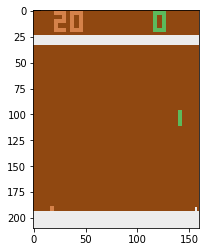

In [18]:
#obs0 = env.reset()
#print("initial observation code:", obs0)

plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)